## MOD Jet Substructure Demo
[Patrick T. Komiske](https://pkomiske.com) and [Eric M. Metodiev](https://www.ericmetodiev.com)

This simple self-contained notebook demonstrates how to obtain the distribution of any jet substructure observable on the MOD-processed CMS Open Data.

The CMS-recorded (`cms`), Pythia-generated (`gen`), and detector-simulated (`sim`) datasets of jets are directly downloaded from Zenodo. Simple defaults are used for observables, jet selections, and particle flow candidate filters, but these can be very easily customized by the user. 

If used with Binder, this requires zero software installation or file downloads. Just run it in your browser. Enjoy!

If these datasets or software packages are helpful in your research, please cite:
* The [MOD jet substructure paper](): "Exploring the Space of Jets with CMS Open Data"
* The [Zenodo records](https://doi.org/10.5281/zenodo.3340205
) of the MOD-processed CMS Open Data and Monte Carlo files
* The [EnergyFlow](https://energyflow.network/faqs/) python package, where more documentation is available

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import energyflow as ef

import modplot

### Read in the Open Data

This cell determines the jet $p_T$, $|\eta|$, and quality selections and reads in the datasets. The defaults are jets with $p_T\in[375,425]$ GeV and $|\eta|<1.9$ of "medium" quality. A small fraction of each dataset is used by default.

**Customize:** You can change the `specs` to any desired jet selection. Make sure to change the corresponding plot stamp description of the selection.

In [2]:
# use a fraction of the full datasets (amount=1.0 uses the full datasets)
amount = 0.01

# select jets with JEC-corrected pT in [375, 425] GeV and |eta| < 1.9, with "medium" quality
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']

# stamp description of the jet selections
legend_label_0 = r'AK5 Jets, $|\eta^{\rm jet}|<1.9$'
legend_label_1 = r'$p_T^{\rm jet}\in [375,425]$ GeV'

# load the CMS (cms), Pythia-generated (gen), and detector-simulated (sim) datasets
cms = ef.mod.load(*specs, dataset='cms', amount=amount)
sim = ef.mod.load(*specs, dataset='sim', amount=amount, store_gens=False)
gen = ef.mod.load(*specs, dataset='gen', amount=amount)

# show the details of the CMS, SIM, and GEN datasets
print(cms)
print(sim)
print(gen)

CMS MODDataset
  Jet Integers - (48956, 6)
    ['fn' 'rn' 'lbn' 'evn' 'npv' 'quality']
  Jet Floats - (48956, 9)
    ['jet_pt' 'jet_y' 'jet_phi' 'jet_m' 'jet_eta' 'jec' 'jet_area'
     'jet_max_nef' 'weight']
  PFCs - (48956,)
    ['pt' 'y' 'phi' 'm' 'pid' 'vertex']
  Filenames - (1223,)

SIM MODDataset
  Jet Integers - (85819, 7)
    ['fn' 'rn' 'lbn' 'evn' 'npv' 'quality' 'hard_pid']
  Jet Floats - (85819, 17)
    ['jet_pt' 'jet_y' 'jet_phi' 'jet_m' 'jet_eta' 'jec' 'jet_area'
     'jet_max_nef' 'gen_jet_pt' 'gen_jet_y' 'gen_jet_phi' 'gen_jet_m'
     'gen_jet_eta' 'hard_pt' 'hard_y' 'hard_phi' 'weight']
  PFCs - (85819,)
    ['pt' 'y' 'phi' 'm' 'pid' 'vertex']
  Filenames - (2331, 2)

GEN MODDataset
  Jet Integers - (82885, 5)
    ['fn' 'rn' 'lbn' 'evn' 'hard_pid']
  Jet Floats - (82885, 9)
    ['jet_pt' 'jet_y' 'jet_phi' 'jet_m' 'jet_eta' 'hard_pt' 'hard_y'
     'hard_phi' 'weight']
  GENs - (82885,)
    ['pt' 'y' 'phi' 'm' 'pid' 'vertex']
  Filenames - (2331, 2)



### Observable and Plot Settings

This cell determines the jet substructure observable being computed and all of the plot settings. The defaults here are for constituent multiplicity.

**Customize:** You can change the `obs` function to any observable. Make sure to change the corresponding plot settings (binnings and labels) in this cell.

In [3]:
# define your observable on the jet (i.e. list of PFC [pT, y, phi, m, PID, vertex])

def obs(jet):
    return len(jet)

# define your histogram binning
bins = np.linspace(0,100,51)

# define the x-axis label and y-axis label
xlabel = r'Constituent Multiplicity $M$'
ylabel = 'Differential Cross Section [nb]'

# specify a particle flow candidate (PFC) filter, defaults to applying CHS only
# settings are: which ('all' or 'charged'), a PFC ptcut (in GeV), and chs (True or False)
filt_args = {'which': 'all', 'pt_cut': 0, 'chs': True}
filt_legend_label = r'CHS'

### Compute Observable Values

This cell filters the particle flow candidates as specified and computes the jet substructure observables for all of the datasets.

The Monte Carlo samples are reweighted based on the K-factors and to match the pileup profile of the data.

In [4]:
# compute the observables on the jets, after filtering the PFCs accordingly
cms_obs = np.asarray([obs(jet[ef.mod.filter_particles(jet, **filt_args)]) for jet in cms.particles])
sim_obs = np.asarray([obs(jet[ef.mod.filter_particles(jet, **filt_args)]) for jet in sim.particles])
gen_obs = np.asarray([obs(jet[ef.mod.filter_particles(jet, **filt_args)]) for jet in gen.particles])

# get weight modifications for sim and gen weights
sim_factors = ef.mod.kfactors('sim', sim.corr_jet_pts, sim.npvs)
gen_factors = ef.mod.kfactors('gen', gen.jet_pts)

### Compute Histograms

This cell computes the value and uncertainty of the histogram bins of the observable distribution for each of the datasets.

In [5]:
# get middle bin values and step size
step = bins[1]-bins[0]
midbins = (bins[1:] + bins[:-1])/2

# cms histogram calculation
cms_hist, cms_errs, _ = modplot.calc_hist(cms_obs, bins=bins, weights=cms.weights, density=False)
cms_hist, cms_errs = cms_hist/step, cms_errs/step

# sim histogram calculation
sim_hist, sim_errs, _ = modplot.calc_hist(sim_obs, bins=bins, weights=sim.weights*sim_factors, density=False)
sim_hist, sim_errs = sim_hist/step, sim_errs/step

# gen histogram calculation
gen_hist, gen_errs, _ = modplot.calc_hist(gen_obs, bins=bins, weights=gen.weights*gen_factors, density=False)
gen_hist, gen_errs = gen_hist/step, gen_errs/step

### Make Plot of Observable Distributions

This cell plots the computed histograms for each dataset in the MOD style.

**Customize:** `modplot.axes` takes more arguments for further customization. The `style` dictionaries can be modified to customize the style of the curves. You can change `stamp_x` and `stamp_y` to move the stamp within the figure.

**Note:** This example uses LaTeX syntax and rendering on the figure text. This may cause errors if moved to your system without a LaTeX matplotlib setup.

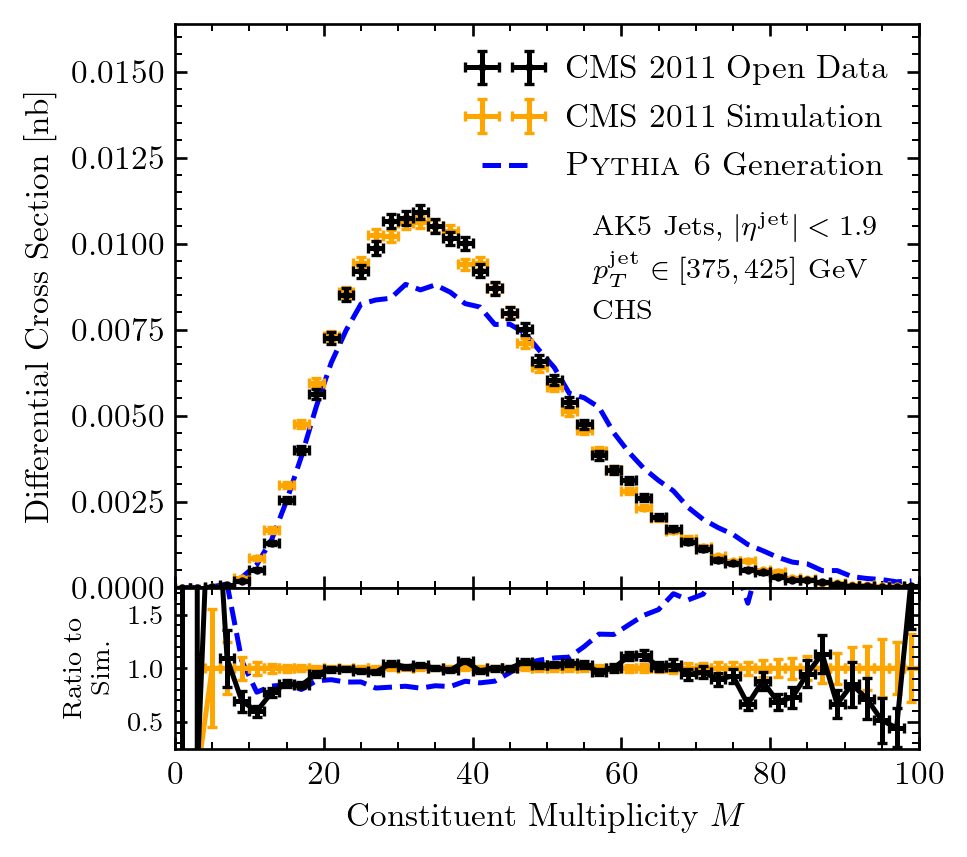

In [6]:
# get axes in MOD plot format
fig, axes = modplot.axes(ratio_plot=True, xlabel=xlabel, ylabel=ylabel, ylim_ratio=(0.25, 1.75),
                         xlim=(min(bins), max(bins)), ylim=(0, 1.5*np.max(cms_hist)))

# tiny regulator
reg = 10**-30

# plot of the cms observable distribution
cms_style = {'lw':1.5, 'capsize':1.5, 'capthick':1, 'markersize':1.5, 'color':'black', 
             'label':'CMS 2011 Open Data'}
axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=3)
axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2, yerr=cms_errs/(sim_hist+reg), 
                 **cms_style, zorder=2)

# plot of the sim observable distribution
sim_style = {'lw':1.5, 'capsize':1.5, 'capthick':1, 'markersize':1.5, 'color':'orange', 
             'label':'CMS 2011 Simulation'}
axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=2)
axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2, yerr=sim_errs/(sim_hist+reg), 
                 **sim_style, zorder=1)

# plot of the gen observable distribution
gen_style = {'lw': 1.5, 'ls': '--', 'color': 'blue', 'label': '\\textsc{Pythia 6} Generation'}
axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
axes[1].plot(midbins, gen_hist/(sim_hist + reg), **gen_style, zorder=0)

# additional plot modifications
stamp_x, stamp_y = 0.56, 0.64
modplot.stamp(stamp_x, stamp_y, ax=axes[0], 
              line_0=legend_label_0, line_1=legend_label_1, line_2=filt_legend_label)
modplot.legend(ax=axes[0], order=[1,2,0])

# save plot (by default in the same directory as this notebook).
# If running on binder, the plot can be accessed by first going to the jupyter file browser
# (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
# after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
# The MOD logo can be optionally added by changing add_watermark to True in the following command.
modplot.save(fig, 'figname', add_watermark=False, tx=51.5, ty=251.5, plots_dir='.')

fig.show()

### The End

We hope you've enjoyed this quick introduction to using the MOD-processed CMS Open Data jet substructure datasets!